In [1]:
total_files = 60

In [2]:
!pip install -q deltalake  --upgrade
!pip install -q duckdb     --upgrade
!pip install -q polars     --upgrade

In [3]:
raw_landing = '/lakehouse/default/Files/download'

In [4]:
# @title
storage_options={"allow_unsafe_rename":"true"}
from psutil import *
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(vCPU +' Memory:'+ str(mem))

2 vCPU Memory:15.0


# Download Data

In [5]:
import pandas as pd
import re ,shutil,glob
from urllib.request import urlopen
import os
import requests
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
def download(url,Path,x):
    #run only once to create an empty log file
    if not os.path.exists(Path):
      os.makedirs(Path, exist_ok=True) 
      os.makedirs(Path+"_log", exist_ok=True)
      log_tb = pa.Table.from_pylist( ['x'], schema=pa.schema({ "file" : pa.string()}))
      pq.write_table(log_tb,Path+"_log/log.parquet")  
    # Regex don't ask I just copy it
    result = urlopen(url).read().decode('utf-8')
    pattern = re.compile(r'[\w.]*.zip')
    filelist1 = pattern.findall(result)
    filelist_unique = dict.fromkeys(filelist1)
    filelist_sorted=sorted(filelist_unique, reverse=True)
    filelist = filelist_sorted[:x]
    ### Read from existing log
    try:
      df = ds.dataset(Path + "_log/log.parquet").to_table().to_pandas()     
      file_loaded= df['file'].unique().tolist()
    except:
      os.makedirs(Path+"_log", exist_ok=True) 
      file_loaded=[os.path.basename(x) for x in glob.glob(Path+'*.zip')]
    current = file_loaded
    files_to_upload = list(set(filelist) - set(current))
    files_to_upload = list(dict.fromkeys(files_to_upload)) 
    print(str(len(files_to_upload)) + ' New File Loaded')
    if len(files_to_upload) != 0 :
      for x in files_to_upload:
           with requests.get(url+x, stream=True) as resp:
            if resp.ok:
              with open(f"{Path}/{x}", "wb") as f:
               for chunk in resp.iter_content(chunk_size=4096):
                f.write(chunk)
      
    #print(log)
    L=[os.path.basename(x) for x in glob.glob(Path+'*.zip')]
    log = pd.DataFrame({'file':L})
    log_tb=pa.Table.from_pandas(log,preserve_index=False)
    #print(log_tb)
    log_schema = pa.schema([pa.field('file', pa.string())])
    log_tb=log_tb.cast(target_schema=log_schema)
    pq.write_table(log_tb,Path+"_log/log.parquet")
    return "done"

In [6]:
import pandas as pd
import multiprocessing
from shutil import unpack_archive
import os
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
def uncompress(x):
        unpack_archive(str(Source+x), str(Destination), 'zip')
def unzip(Source, Destination,Nbr_Files_to_Download):
    
    #run only once to create an empty log file
    if not os.path.exists(Destination):
      os.makedirs(Destination, exist_ok=True) 
      os.makedirs(Destination+"_log", exist_ok=True)
      log_tb = pa.Table.from_pylist( ['x'], schema=pa.schema({ "file" : pa.string()}))
      pq.write_table(log_tb,Destination+"_log/log.parquet")  
    # check zip files
    try:
     df = ds.dataset(Source + "_log/log.parquet").to_table().to_pandas()     
     filelist_unique= df['file'].unique()
     filelist=filelist_unique.tolist()
    except: 
     filelist=[os.path.basename(x) for x in glob.glob(Source+'*.zip')]
    filelist =sorted(filelist, reverse=True)
    ### checl the unzipped files already
    df = ds.dataset(Destination + "_log/log.parquet").to_table().to_pandas()     
    file_loaded= df['file'].unique()
    current = file_loaded.tolist()
    files_to_upload = list(set(filelist) - set(current))
    files_to_upload = list(dict.fromkeys(files_to_upload))[:Nbr_Files_to_Download] 
    #unzip only the delta
    print(str(len(files_to_upload)) + ' New File uncompressed')
    if len(files_to_upload) != 0 :
      with multiprocessing.Pool() as pool:
       for _ in pool.imap_unordered(uncompress, files_to_upload, chunksize=1):
         pass
      existing_file = pd.DataFrame( file_loaded)
      new_file = pd.DataFrame(  files_to_upload)
      log = pd.concat ([new_file,existing_file], ignore_index=True)
      #print(log)
      log.rename(columns={0: 'file'}, inplace=True)
      log_tb=pa.Table.from_pandas(log,preserve_index=False)
      #print(log_tb)
      log_schema = pa.schema([pa.field('file', pa.string())])
      log_tb=log_tb.cast(target_schema=log_schema)
      pq.write_table(log_tb,Destination+"_log/log.parquet")
      return "done"
    else:
     return "nothing to see here"

In [7]:
download("https://nemweb.com.au/Reports/Current/Daily_Reports/",raw_landing+"/zip/",total_files)

0 New File Loaded


'done'

In [8]:
Source      = raw_landing+"/zip/"
Destination = raw_landing+"/csv/"
unzip(Source,Destination,total_files)

0 New File uncompressed


'nothing to see here'

# DuckDB

In [9]:
# @title
import duckdb
def duckdb_clean_csv(x):
	raw =duckdb.sql(F"""from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)

	df=duckdb.sql(""" select UNIT, DUID,filename,cast(columns(*exclude(DUID,UNIT,SETTLEMENTDATE,I,XX,filename)) as double),cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	isoyear (cast (SETTLEMENTDATE as timestamp)) as year  from raw  """).record_batch()

	write_deltalake(f"/lakehouse/default/Tables/T{total_files}/duckdb",df, mode="append", partition_by=['year'], storage_options= storage_options)
	return "done"


# Polars

In [10]:
def polars_clean_csv(x):
  import polars as pl
  schema ={'I': pl.String,'UNIT': pl.String,'XX': pl.String,'VERSION': pl.String,'SETTLEMENTDATE': pl.String,'RUNNO': pl.String,
    'DUID': pl.String,'INTERVENTION': pl.String,'DISPATCHMODE': pl.String,'AGCSTATUS': pl.String,'INITIALMW': pl.String,
    'TOTALCLEARED': pl.String,'RAMPDOWNRATE': pl.String,'RAMPUPRATE': pl.String,'LOWER5MIN': pl.String,
    'LOWER60SEC': pl.String,'LOWER6SEC': pl.String,'RAISE5MIN': pl.String,'RAISE60SEC': pl.String,
    'RAISE6SEC': pl.String,'MARGINAL5MINVALUE': pl.String,'MARGINAL60SECVALUE': pl.String,
    'MARGINAL6SECVALUE': pl.String,'MARGINALVALUE': pl.String,'VIOLATION5MINDEGREE': pl.String,
    'VIOLATION60SECDEGREE': pl.String,'VIOLATION6SECDEGREE': pl.String,'VIOLATIONDEGREE': pl.String,
    'LOWERREG': pl.String,'RAISEREG': pl.String,'AVAILABILITY': pl.String,'RAISE6SECFLAGS': pl.String,
    'RAISE60SECFLAGS': pl.String,'RAISE5MINFLAGS': pl.String,'RAISEREGFLAGS': pl.String,
    'LOWER6SECFLAGS': pl.String,'LOWER60SECFLAGS': pl.String,'LOWER5MINFLAGS': pl.String,
    'LOWERREGFLAGS': pl.String,'RAISEREGAVAILABILITY': pl.String,'RAISEREGENABLEMENTMAX': pl.String,
    'RAISEREGENABLEMENTMIN': pl.String,'LOWERREGAVAILABILITY': pl.String,'LOWERREGENABLEMENTMAX': pl.String,
    'LOWERREGENABLEMENTMIN': pl.String,'RAISE6SECACTUALAVAILABILITY': pl.String,
    'RAISE60SECACTUALAVAILABILITY': pl.String,'RAISE5MINACTUALAVAILABILITY': pl.String,
    'RAISEREGACTUALAVAILABILITY': pl.String,'LOWER6SECACTUALAVAILABILITY': pl.String,
    'LOWER60SECACTUALAVAILABILITY': pl.String,'LOWER5MINACTUALAVAILABILITY': pl.String,'LOWERREGACTUALAVAILABILITY': pl.String}
  raw = pl.scan_csv(x, skip_rows=1, schema=schema, has_header=False,truncate_ragged_lines=True)
  transform =(
      raw
      .filter( (pl.col("I")=='D') &  (pl.col("UNIT")=='DUNIT') & (pl.col("VERSION")=='3') )
      .drop("XX","I")
  )
 
  z = transform.with_columns(pl.col("SETTLEMENTDATE").str.to_datetime())
  columns = list(set(transform.collect_schema().names()) - {'SETTLEMENTDATE','DUID','UNIT','xxx'})
  final=z.with_columns(pl.col(columns).cast(pl.Float64),year=pl.col("SETTLEMENTDATE").dt.iso_year()).collect(streaming=True)
  final.write_delta(f"/lakehouse/default/Tables/T{total_files}/polars",mode="append", storage_options= storage_options)
  return "done"

# Pandas

In [11]:
# @title
import pandas as pd
import pyarrow as pa
def pandas_clean_csv(chunk):
    appended_data = []
    for filename in chunk:
        # Read only necessary columns
        df = pd.read_csv(filename, skiprows=1,dtype=str, names=range(131), keep_default_na=False,  index_col=False)
        df = df.iloc[:, :53]
        df = df.rename(columns={1: 'DISPATCH', 3: 'VERSION'}).query('DISPATCH=="DUNIT" and VERSION=="3"')
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.rename(columns={'3': 'version', 'DUNIT': 'UNIT'})
        df = df.drop(columns=['I'])
        df.drop([""], axis=1, inplace=True)
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
        columns = list(set(df.columns) - {'SETTLEMENTDATE', 'DUID', 'UNIT'})
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce', dtype_backend='pyarrow')
        df['year'] = df['SETTLEMENTDATE'].dt.year
        appended_data.append(df)
    appended_data = pd.concat(appended_data, ignore_index=True)
    xx= pa.Table.from_pandas(appended_data,preserve_index=False)
    write_deltalake(f"/lakehouse/default/Tables/T{total_files}/pandas",xx,mode="append", partition_by=['year'], storage_options= storage_options)
    return "done"

# Pyarrow

In [12]:
from pyarrow import csv
import pyarrow.compute as pc
import pyarrow as pa
import pyarrow.dataset as ds
def pyarrow_clean_csv(files_to_upload_full_Path):
  new_schema = pa.schema([
  ('I', pa.string()),  ('UNIT', pa.string()),  ('XX', pa.string()),  ('VERSION', pa.float64()),  ('SETTLEMENTDATE', pa.string()),  ('RUNNO', pa.float64()),  ('DUID', pa.string()),  ('INTERVENTION', pa.float64()),
  ('DISPATCHMODE', pa.float64()),  ('AGCSTATUS', pa.float64()),  ('INITIALMW', pa.float64()),  ('TOTALCLEARED', pa.float64()),  ('RAMPDOWNRATE', pa.float64()),  ('RAMPUPRATE', pa.float64()),  ('LOWER5MIN', pa.float64()),
  ('LOWER60SEC', pa.float64()),  ('LOWER6SEC', pa.float64()),  ('RAISE5MIN', pa.float64()),  ('RAISE60SEC', pa.float64()),  ('RAISE6SEC', pa.float64()),  ('MARGINAL5MINVALUE', pa.float64()),  ('MARGINAL60SECVALUE', pa.float64()),
  ('MARGINAL6SECVALUE', pa.float64()),  ('MARGINALVALUE', pa.float64()),  ('VIOLATION5MINDEGREE', pa.float64()),  ('VIOLATION60SECDEGREE', pa.float64()),  ('VIOLATION6SECDEGREE', pa.float64()),  ('VIOLATIONDEGREE', pa.float64()),
  ('LOWERREG', pa.float64()),  ('RAISEREG', pa.float64()),  ('AVAILABILITY', pa.float64()),  ('RAISE6SECFLAGS', pa.float64()),  ('RAISE60SECFLAGS', pa.float64()),  ('RAISE5MINFLAGS', pa.float64()),
  ('RAISEREGFLAGS', pa.float64()),  ('LOWER6SECFLAGS', pa.float64()),  ('LOWER60SECFLAGS', pa.float64()),  ('LOWER5MINFLAGS', pa.float64()),  ('LOWERREGFLAGS', pa.float64()),  ('RAISEREGAVAILABILITY', pa.float64()),
  ('RAISEREGENABLEMENTMAX', pa.float64()),  ('RAISEREGENABLEMENTMIN', pa.float64()),  ('LOWERREGAVAILABILITY', pa.float64()),  ('LOWERREGENABLEMENTMAX', pa.float64()),  ('LOWERREGENABLEMENTMIN', pa.float64()),
  ('RAISE6SECACTUALAVAILABILITY', pa.float64()),  ('RAISE60SECACTUALAVAILABILITY', pa.float64()),  ('RAISE5MINACTUALAVAILABILITY', pa.float64()),  ('RAISEREGACTUALAVAILABILITY', pa.float64()),  ('LOWER6SECACTUALAVAILABILITY', pa.float64()),
  ('LOWER60SECACTUALAVAILABILITY', pa.float64()),  ('LOWER5MINACTUALAVAILABILITY', pa.float64()),  ('LOWERREGACTUALAVAILABILITY', pa.float64()),
    ])
  ReadOptions = csv.ReadOptions(column_names=new_schema.names,skip_rows=1)
  ParseOptions  = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
  ConvertOptions = csv.ConvertOptions(strings_can_be_null=True)
  format = ds.CsvFileFormat(parse_options = ParseOptions ,convert_options = ConvertOptions ,read_options = ReadOptions  )
  raw = ds.dataset(files_to_upload_full_Path, format =format).filter((pc.field('I') == 'D') & (pc.field('UNIT') == 'DUNIT') & (pc.field('VERSION') == 3)).to_table().cast(new_schema)
  df= raw.drop_columns(['I','XX'])
  df = df.set_column(df.schema.get_field_index("SETTLEMENTDATE"), "SETTLEMENTDATE",pc.strptime(df['SETTLEMENTDATE'], format="%Y/%m/%d %H:%M:%S", unit='s').cast(pa.timestamp("s")))
  df = df.add_column(0,"year", pc.year(df['SETTLEMENTDATE']))
  write_deltalake(f"/lakehouse/default/Tables/T{total_files}/pyarrow",df,mode="append", partition_by=['year'], storage_options= storage_options)
  return "done"

# Daft

In [13]:
def daft_clean_csv(files_to_upload_full_Path):
	!pip install   getdaft
	import daft
	from daft import DataType, col
	schema={
				'I': DataType.string(),'UNIT': DataType.string(),'XX': DataType.string(),'VERSION': DataType.string(),'SETTLEMENTDATE': DataType.string(),'RUNNO': DataType.string(),
				'DUID': DataType.string(),'INTERVENTION': DataType.string(),'DISPATCHMODE': DataType.string(),'AGCSTATUS': DataType.string(),'INITIALMW': DataType.string(),
				'TOTALCLEARED': DataType.string(),'RAMPDOWNRATE': DataType.string(),'RAMPUPRATE': DataType.string(),'LOWER5MIN': DataType.string(),
				'LOWER60SEC': DataType.string(),'LOWER6SEC': DataType.string(),'RAISE5MIN': DataType.string(),'RAISE60SEC': DataType.string(),
				'RAISE6SEC': DataType.string(),'MARGINAL5MINVALUE': DataType.string(),'MARGINAL60SECVALUE': DataType.string(),
				'MARGINAL6SECVALUE': DataType.string(),'MARGINALVALUE': DataType.string(),'VIOLATION5MINDEGREE': DataType.string(),
				'VIOLATION60SECDEGREE': DataType.string(),'VIOLATION6SECDEGREE': DataType.string(),'VIOLATIONDEGREE': DataType.string(),
				'LOWERREG': DataType.string(),'RAISEREG': DataType.string(),'AVAILABILITY': DataType.string(),'RAISE6SECFLAGS': DataType.string(),
				'RAISE60SECFLAGS': DataType.string(),'RAISE5MINFLAGS': DataType.string(),'RAISEREGFLAGS': DataType.string(),
				'LOWER6SECFLAGS': DataType.string(),'LOWER60SECFLAGS': DataType.string(),'LOWER5MINFLAGS': DataType.string(),
				'LOWERREGFLAGS': DataType.string(),'RAISEREGAVAILABILITY': DataType.string(),'RAISEREGENABLEMENTMAX': DataType.string(),
				'RAISEREGENABLEMENTMIN': DataType.string(),'LOWERREGAVAILABILITY': DataType.string(),'LOWERREGENABLEMENTMAX': DataType.string(),
				'LOWERREGENABLEMENTMIN': DataType.string(),'RAISE6SECACTUALAVAILABILITY': DataType.string(),
				'RAISE60SECACTUALAVAILABILITY': DataType.string(),'RAISE5MINACTUALAVAILABILITY': DataType.string(),
				'RAISEREGACTUALAVAILABILITY': DataType.string(),'LOWER6SECACTUALAVAILABILITY': DataType.string(),
				'LOWER60SECACTUALAVAILABILITY': DataType.string(),'LOWER5MINACTUALAVAILABILITY': DataType.string(),'LOWERREGACTUALAVAILABILITY': DataType.string()}
	df = daft.read_csv(files_to_upload_full_Path,schema=schema, infer_schema=False, has_headers=False, allow_variable_columns=True)
	df = df.where((df["UNIT"] == 'DUNIT' ) & (df["VERSION"] == '3') & (df["I"] == 'D'))
	df = df.exclude('I','XX')
	df_cols = list(set(df.column_names) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY'})
	for col_name in df_cols:
			df = df.with_column(col_name, col(col_name).cast(DataType.float64()))
	df = df.with_column("SETTLEMENTDATE", df["SETTLEMENTDATE"].str.to_datetime("%Y/%m/%d %H:%M:%S"))
	df = df.with_column('DATE', col('SETTLEMENTDATE').cast(DataType.date()))
	df = df.with_column('year', col('SETTLEMENTDATE').dt.year()).to_arrow()
	write_deltalake(f"/lakehouse/default/Tables/T{total_files}/daft",df, mode="append", partition_by=['year'], storage_options= storage_options)
	return "done"

# sqlframe

In [14]:
def sqlframe_clean_csv(files_to_upload_full_Path):
  !pip install -q sqlframe
  import duckdb
  from sqlframe.duckdb.session import DuckDBSession
  from sqlframe.duckdb import functions as F
  session = DuckDBSession()
  df = session.read.load(
      files_to_upload_full_Path,
      schema="""I VARCHAR, UNIT VARCHAR, XX VARCHAR, VERSION VARCHAR, SETTLEMENTDATE VARCHAR, RUNNO VARCHAR, DUID VARCHAR,
      INTERVENTION VARCHAR, DISPATCHMODE VARCHAR, AGCSTATUS VARCHAR, INITIALMW VARCHAR, TOTALCLEARED VARCHAR, RAMPDOWNRATE VARCHAR,
      RAMPUPRATE VARCHAR, LOWER5MIN VARCHAR, LOWER60SEC VARCHAR, LOWER6SEC VARCHAR, RAISE5MIN VARCHAR, RAISE60SEC VARCHAR, RAISE6SEC VARCHAR,
      MARGINAL5MINVALUE VARCHAR, MARGINAL60SECVALUE VARCHAR, MARGINAL6SECVALUE VARCHAR, MARGINALVALUE VARCHAR, VIOLATION5MINDEGREE VARCHAR,
      VIOLATION60SECDEGREE VARCHAR, VIOLATION6SECDEGREE VARCHAR, VIOLATIONDEGREE VARCHAR, LOWERREG VARCHAR, RAISEREG VARCHAR, AVAILABILITY VARCHAR, 
      RAISE6SECFLAGS VARCHAR, RAISE60SECFLAGS VARCHAR, RAISE5MINFLAGS VARCHAR, RAISEREGFLAGS VARCHAR, LOWER6SECFLAGS VARCHAR, LOWER60SECFLAGS VARCHAR,
      LOWER5MINFLAGS VARCHAR, LOWERREGFLAGS VARCHAR, RAISEREGAVAILABILITY VARCHAR, RAISEREGENABLEMENTMAX VARCHAR, RAISEREGENABLEMENTMIN VARCHAR, 
      LOWERREGAVAILABILITY VARCHAR, LOWERREGENABLEMENTMAX VARCHAR, LOWERREGENABLEMENTMIN VARCHAR, RAISE6SECACTUALAVAILABILITY VARCHAR,
      RAISE60SECACTUALAVAILABILITY VARCHAR, RAISE5MINACTUALAVAILABILITY VARCHAR, RAISEREGACTUALAVAILABILITY VARCHAR,
      LOWER6SECACTUALAVAILABILITY VARCHAR, LOWER60SECACTUALAVAILABILITY VARCHAR, LOWER5MINACTUALAVAILABILITY VARCHAR,
      LOWERREGACTUALAVAILABILITY VARCHAR""",
      format="csv", skip=1, header=1, all_varchar=1, filename=1, null_padding=True, ignore_errors=1, auto_detect=False)\
      .filter("unit='DUNIT' and version =3 and i='D'")\
      .drop('xx','I')\
      .withColumn('SETTLEMENTDATE',F.to_timestamp('SETTLEMENTDATE',"yyyy/MM/dd HH:mm:ss"))\
      .withColumn("PRIORITY", F.lit(1))
  exclude_list = ['settlementdate','duid','filename','unit','priority']
  df = df.withColumns({i:F.col(i).cast("double") for i in df.columns if i not in exclude_list})
  df = df.withColumn('DATE', F.to_date(F.col('SETTLEMENTDATE')))\
        .withColumn('YEAR', F.year(F.col('SETTLEMENTDATE')))
  write_deltalake(f"/lakehouse/default/Tables/T{total_files}/sqlframe",df.toArrow(batch_size=1000*2048), mode="append", partition_by=['year'], storage_options= storage_options)
  return "done"

# Ibis

In [15]:
def ibis_clean_csv(files_to_upload_full_Path):
 !pip install -q 'ibis-framework'
 import ibis
 import ibis.expr.datatypes as dt
 schema={
			'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
			'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
			'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
			'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
			'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
			'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
			'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
			'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
			'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
			'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
			'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
			'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
			'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
			'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
			'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
			'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
		}
 raw = ibis.read_csv(files_to_upload_full_Path,Skip=1,header =0,all_varchar=1,columns =schema,filename =1,null_padding = 1,ignore_errors=1,auto_detect=0)
 DUNIT = raw.filter((raw.UNIT == "DUNIT") & (raw.VERSION  == '3') & (raw.I  == 'D')).drop("XX","I")
 DUNIT = DUNIT.cast({"SETTLEMENTDATE": dt.Timestamp(timezone="UTC")})
 DUNIT = DUNIT.mutate(date=DUNIT.SETTLEMENTDATE.cast("date"), year=DUNIT.SETTLEMENTDATE.year(),)
 df_cols = list(set(DUNIT.columns) - {'SETTLEMENTDATE','DUID','filename','UNIT','date','year'})
 DUNIT = DUNIT.cast({col_name: "double" for col_name in df_cols})
 DUNIT.to_delta(f"/lakehouse/default/Tables/T{total_files}/ibis",mode="append", partition_by=['year'], storage_options= storage_options)
 return "done"

# Run Test

In [16]:
# @title
import pandas as pd
import time
from datetime import datetime
from deltalake.writer import write_deltalake
def run_test(engine,chunk_len):
    results = pd.DataFrame(columns=['time','Engine','step','total_files','duration'])
    start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    appended_data = []
    for i in range(0, len(files_to_upload_full_Path), chunk_len):
      chunk = files_to_upload_full_Path[i:i + chunk_len]
      start = time.time()
      eval(f"{engine}_clean_csv(chunk)")
      print(f'{engine} :' + str(time.time()-start))
      appended_data.append(pd.DataFrame([[start_time,engine,i,total_files,time.time()-start]], columns=results.columns))
    appended_data = pd.concat(appended_data, ignore_index=True)
    write_deltalake("/lakehouse/default/Tables/dbo/results",appended_data, mode="append", storage_options= storage_options)

In [ ]:
import glob,os
Source = raw_landing+"/csv/"
list_files=[os.path.basename(x) for x in glob.glob(Source+'*.CSV')]
files_to_upload_full_Path = [Source + i for i in list_files][:total_files]
for engine,max_chunk in [("pandas",60),("polars",60),("pyarrow",60),('duckdb',60),('ibis',60),('sqlframe',60),('daft',60)]:
 run_test(engine,max_chunk)

# Results

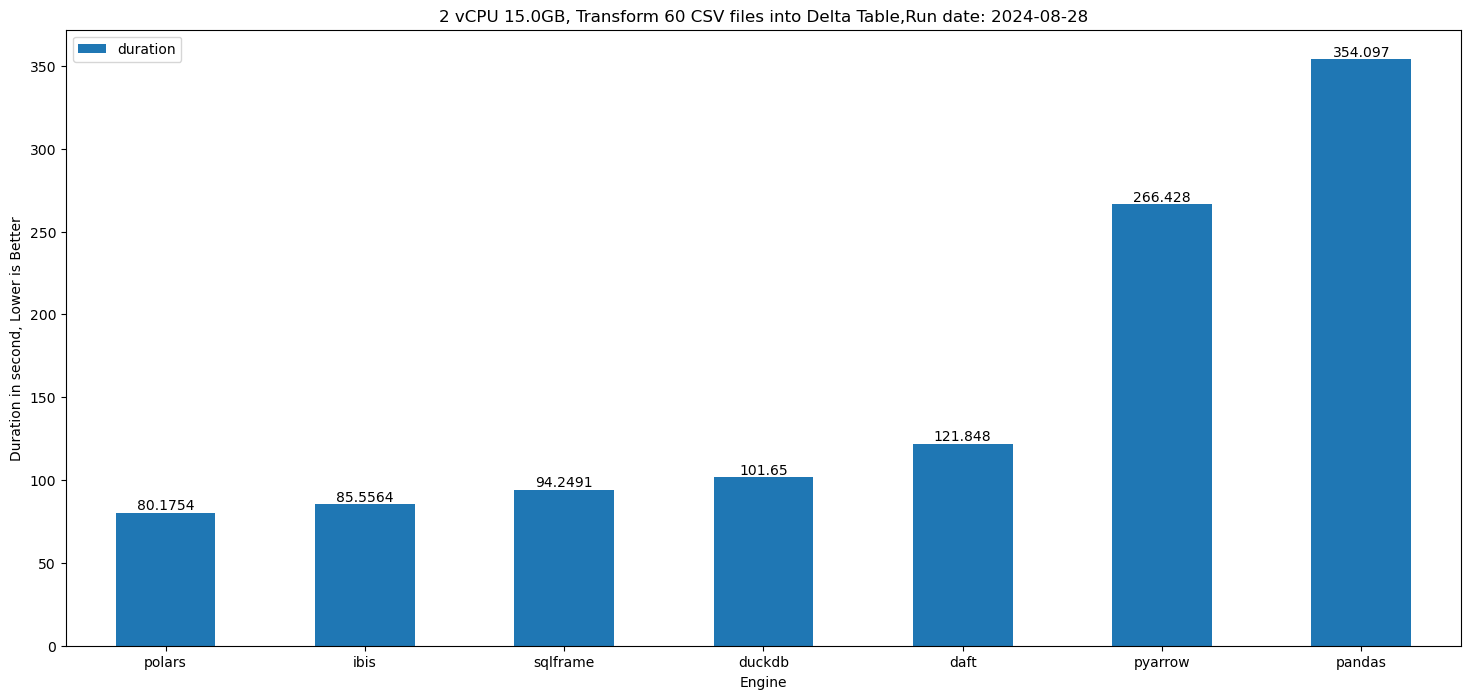

In [19]:
import duckdb
import time
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = vCPU+' '+str(mem)+'GB'+ ', Transform  CSV files and save as Delta Table,Run date: '+ str(time.strftime("%Y-%m-%d"))

raw = duckdb.sql(f""" select Engine, date_trunc('day',cast(time as TIMESTAMP )) as day,step, avg(duration) as duration
             from delta_scan('/lakehouse/default/Tables/dbo/results') where total_files = {total_files}
             group by all """)
xx = duckdb.sql(" select Engine, sum(duration) as duration from raw group by all order by duration").df()
runtime = vCPU+' '+str(mem)+'GB'+ ', Transform '+ str(total_files)+' CSV files into Delta Table,Run date: '+ str(time.strftime("%Y-%m-%d"))
ax = xx.plot.bar(rot=0,x='Engine',title= runtime,ylabel='Duration in second, Lower is Better',figsize=(18,8))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')